In [2]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [3]:
results_dir = 'results/'

In [4]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [5]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [6]:
os.listdir(results_dir)

['adultsDE',
 'adultsDE.zip',
 'adults_de.pkl',
 'annotation.csv',
 'annotation_adult.csv',
 'chimpDE',
 'chimp_de.pkl',
 'expression.csv',
 'expression_adult.csv',
 'humanDE',
 'human_de.pkl',
 'macaqueDE',
 'macaque_de.pkl',
 'markers_velmeshev.xlsx']

## Load files

### Load pseudobulk files

In [7]:
pb_dir_path = '../data/pseudobulks/'

In [8]:
os.listdir('../data/pseudobulks/')

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

### DE results

In [9]:
os.listdir(results_dir + 'humanDE')

['degenes_L1.csv',
 'degenes_L2.csv',
 'degenes_L3.csv',
 'degenes_L4.csv',
 'degenes_L5.csv',
 'degenes_L6.csv',
 'degenes_WM.csv']

In [10]:
human_de = {layer:pd.read_csv(results_dir + f'humanDE/degenes_{layer}.csv', index_col=0) for layer in layers}
chimp_de = {layer:pd.read_csv(results_dir + f'chimpDE/degenes_{layer}.csv', index_col=0) for layer in layers}
macaque_de = {layer:pd.read_csv(results_dir + f'macaqueDE/degenes_{layer}.csv', index_col=0) for layer in layers}
adults_de = {layer:pd.read_csv(results_dir + f'adultsDE/degenes_{layer}.csv', index_col=0) for layer in layers}

# Explore the results

## Add multiple-test correction

In [11]:
from statsmodels.stats.multitest import multipletests

def multipletest_correction(dict_with_df):
    for layer, df in dict_with_df.items():
        mult_test = multipletests(df['PValue'], method='fdr_bh')
        df['p_val_adj'] = mult_test[1]

multipletest_correction(human_de)
multipletest_correction(chimp_de)
multipletest_correction(macaque_de)
multipletest_correction(adults_de)

human_de['L1'].head()

logFC    logCPM         F    PValue  p_val_adj
A1BG  -0.469291  8.707962  5.461037  0.024055   0.102840
AAAS   0.044950  8.415859  0.096263  0.758256   0.897767
AACS  -0.197358  8.537271  4.923438  0.030589   0.121801
AADAT  0.161245  8.534666  3.247336  0.077524   0.236195
AAGAB -0.214563  8.468644  3.037362  0.088496   0.259084

In [12]:
import pickle

with open('results/human_de.pkl', 'wb') as f:
    pickle.dump(human_de, f)

with open('results/chimp_de.pkl', 'wb') as f:
    pickle.dump(chimp_de, f)

with open('results/macaque_de.pkl', 'wb') as f:
    pickle.dump(macaque_de, f)

with open('results/adults_de.pkl', 'wb') as f:
    pickle.dump(adults_de, f)

## Load files

In [13]:
import pickle

with open("results/human_de.pkl", "rb") as file:
    human_de = pickle.load(file)

with open("results/chimp_de.pkl", "rb") as file:
    chimp_de = pickle.load(file)

with open("results/macaque_de.pkl", "rb") as file:
    macaque_de = pickle.load(file)

with open("results/adults_de.pkl", "rb") as file:
    adults_de = pickle.load(file)

## Summary for each comparison

In [14]:
def summary_de(de_dict):
    summary_dict = dict()
    for layer, df in de_dict.items():
        up_reg = df[(df.p_val_adj < 0.05) & (df.logFC > 0)].shape[0]
        down_reg = df[(df.p_val_adj < 0.05) & (df.logFC < 0)].shape[0]
        not_sign = df.shape[0] - up_reg - down_reg
        summary_dict[layer] = [up_reg, not_sign, down_reg]
    summary_df = pd.DataFrame(summary_dict, index=['up_reg', 'not_sign', 'down_reg'])
    return summary_df

In [15]:
print("Summary for human")
summary_de(human_de)

Summary for human


L1    L2    L3    L4    L5    L6     WM
up_reg     919   875   809   739   950   642    158
not_sign  8658  8892  9298  9334  9018  9527  10367
down_reg   983   793   453   487   592   391     35

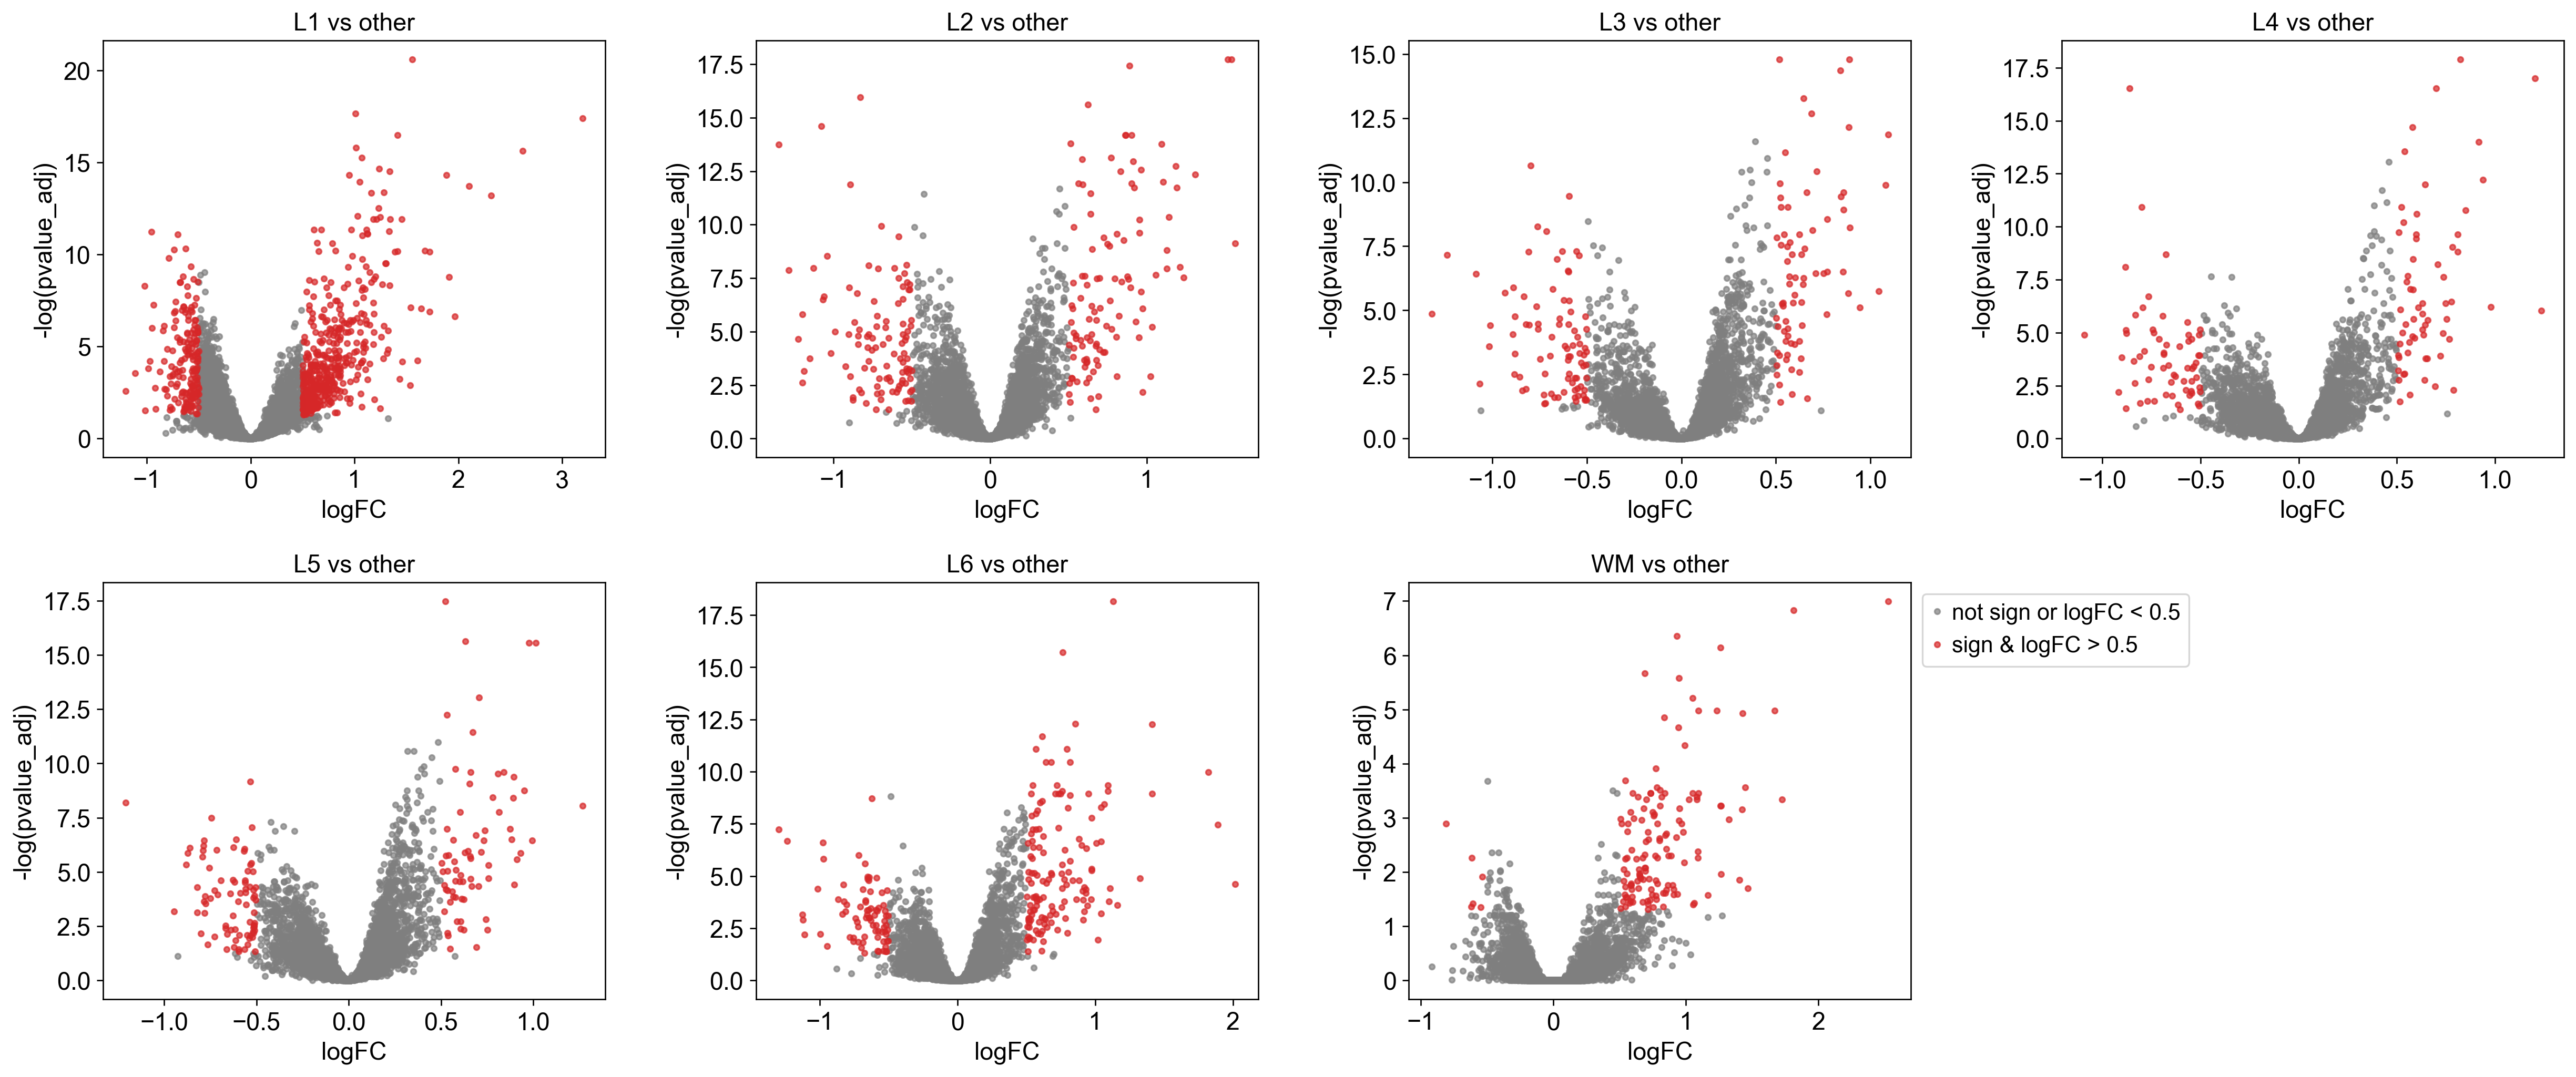

In [16]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(human_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

In [17]:
print("Summary for chimpanzee")
summary_de(chimp_de)

Summary for chimpanzee


L1    L2    L3    L4    L5    L6    WM
up_reg     574   262   372   401   209   103    33
not_sign  6490  7127  7013  6949  7255  7394  7497
down_reg   477   152   156   191    77    44    11

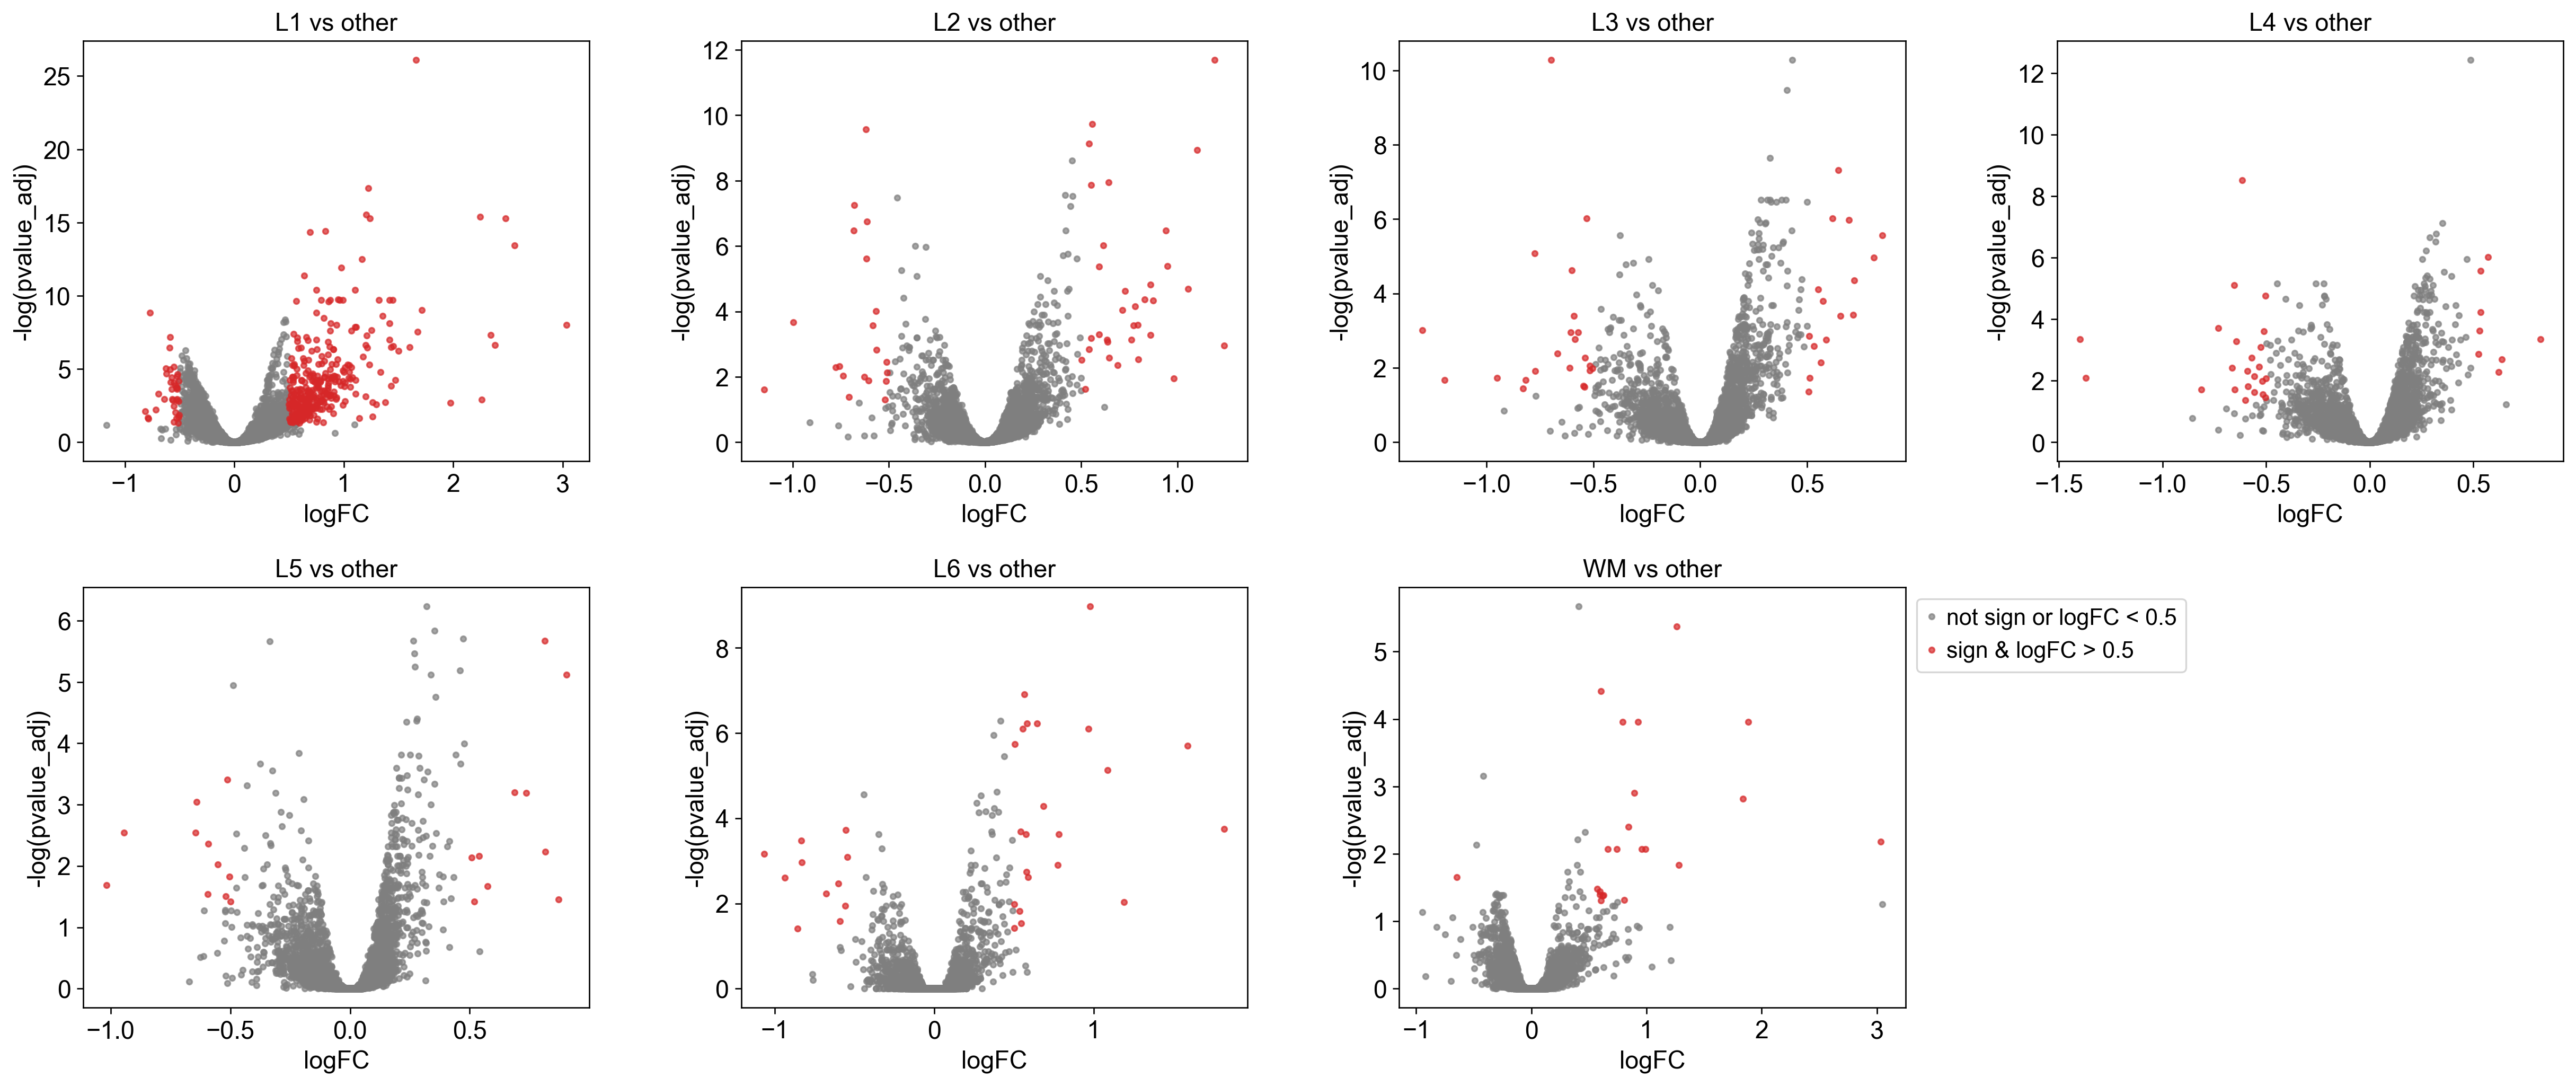

In [18]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(chimp_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

In [19]:
print("Summary for macaque")
summary_de(macaque_de)

Summary for macaque


L1    L2    L3    L4    L5    L6    WM
up_reg     781   706  1063   843   724   281  1208
not_sign  6363  6637  6179  6416  6571  7343  5213
down_reg   670   471   572   555   519   190  1393

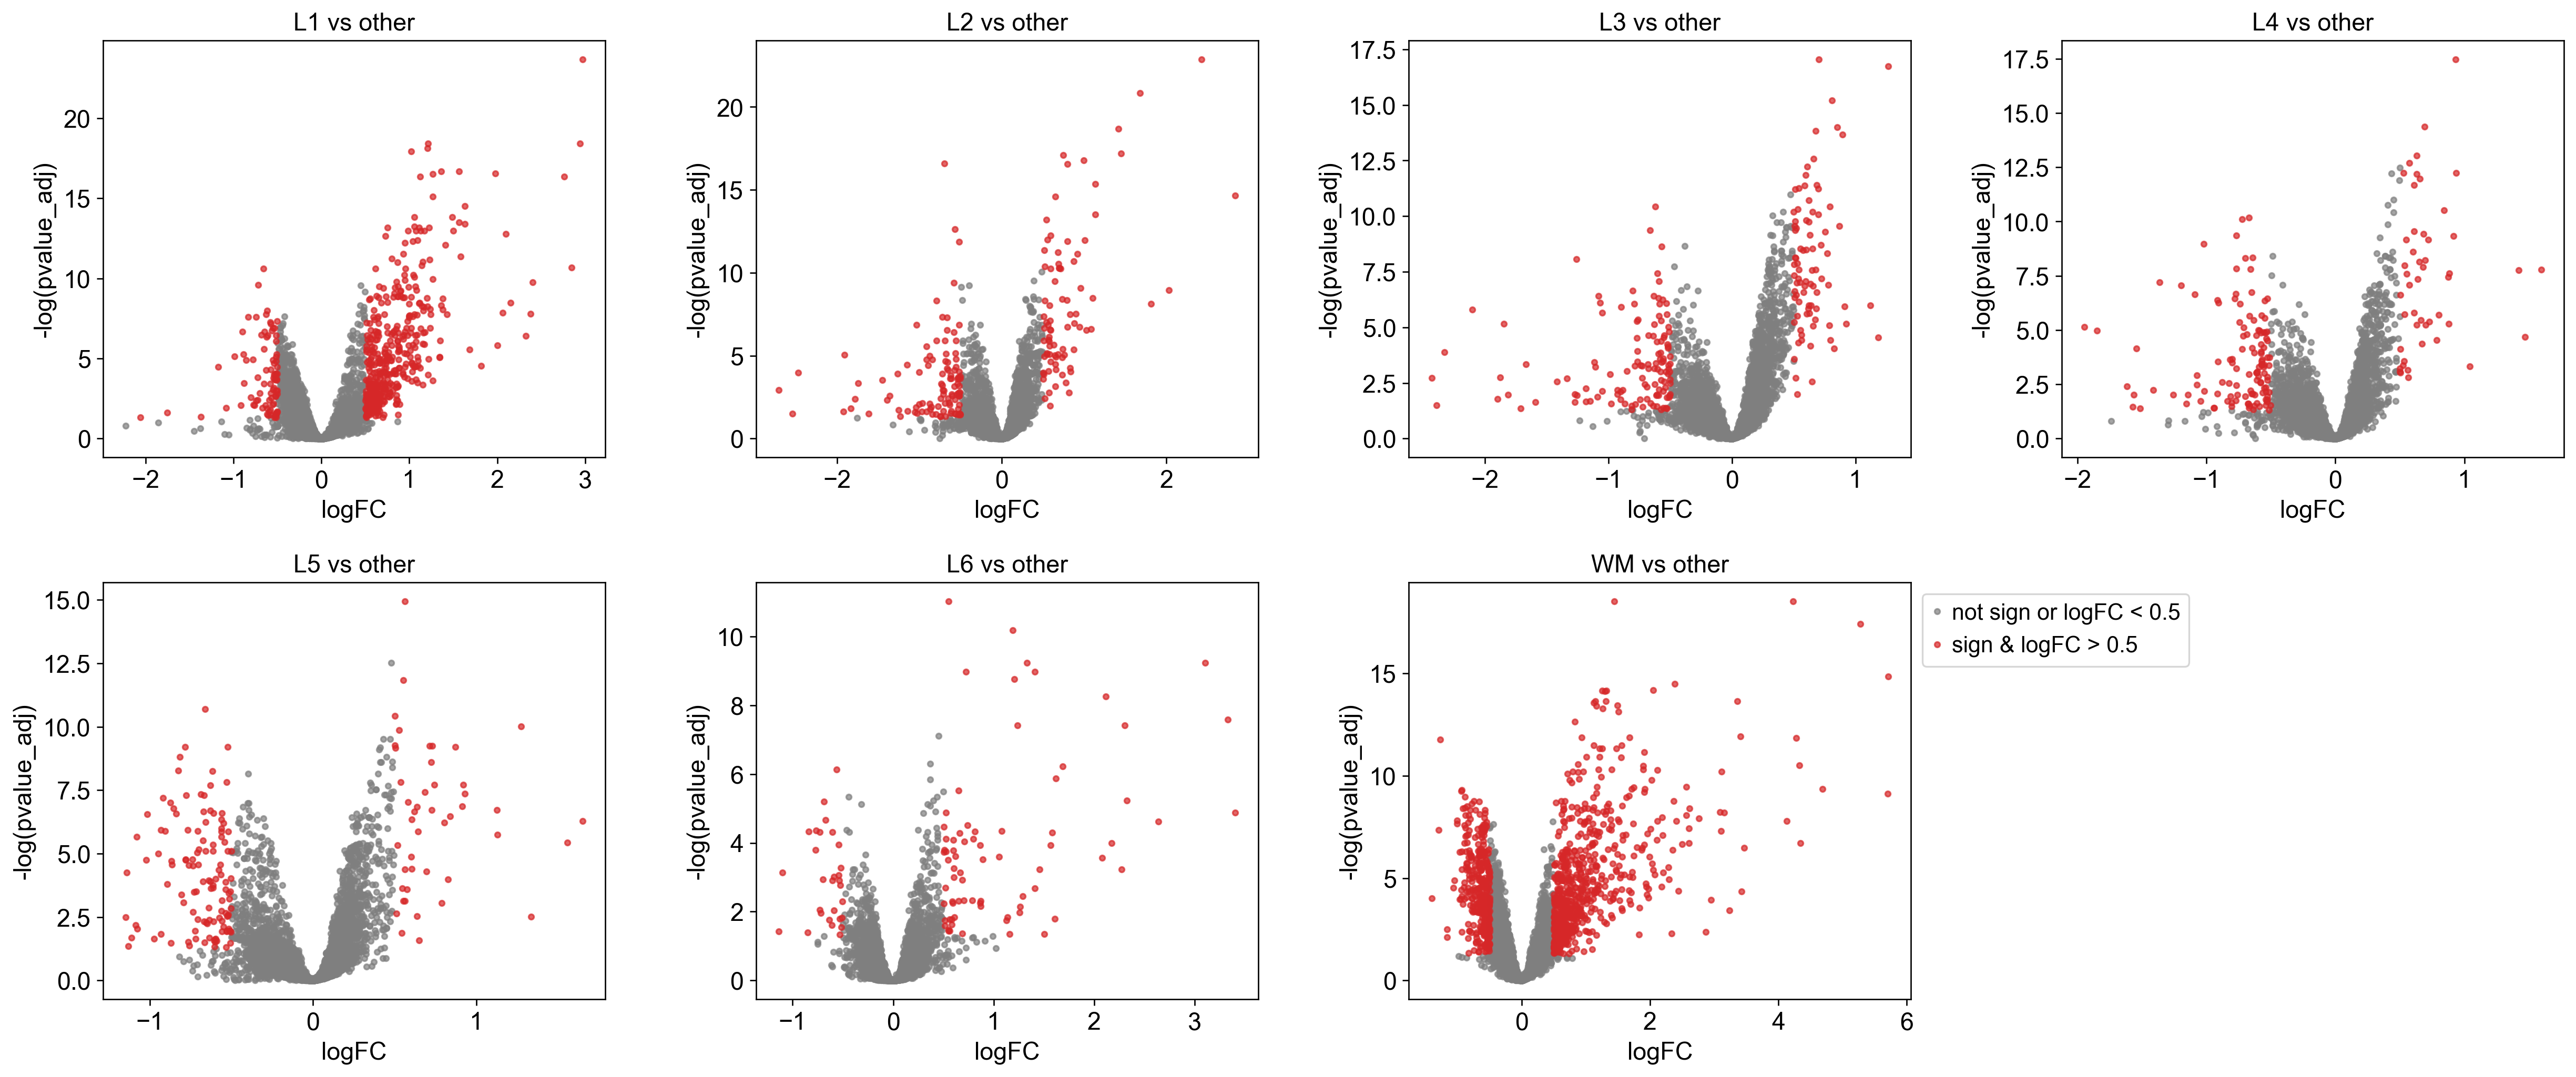

In [20]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(macaque_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

In [21]:
print("Summary for adults")
summary_de(adults_de)

Summary for adults


L1    L2    L3    L4    L5     L6    WM
up_reg      763  1373  1337  1451  1296    784  2521
not_sign  10441  9369  9659  9517  9751  10703  6591
down_reg    736  1198   944   972   893    453  2828

d:\Projects\spatialMPFC\venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


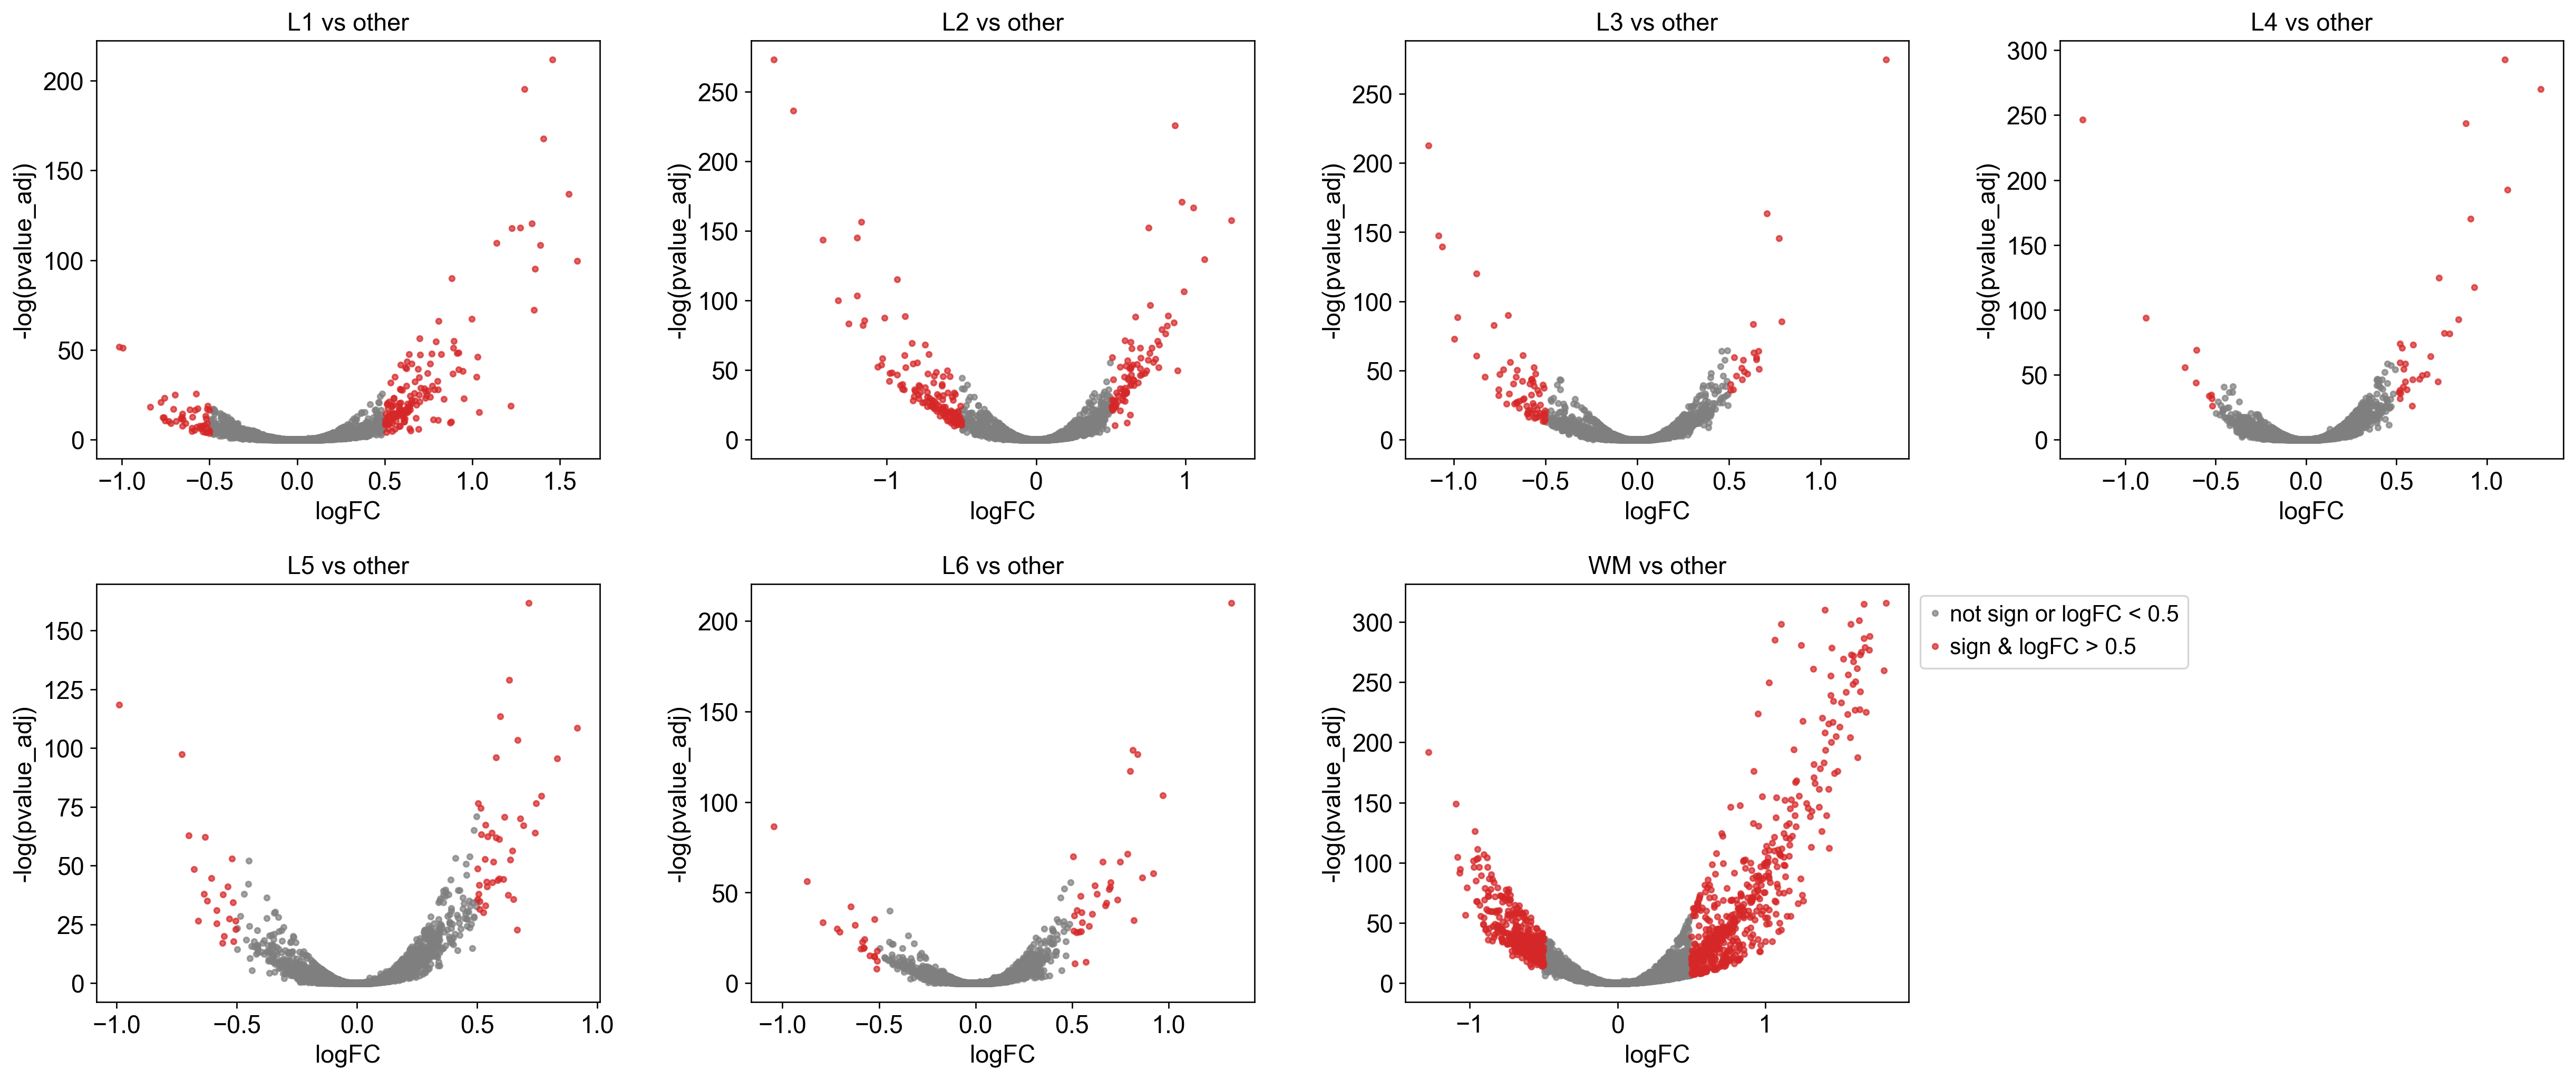

In [22]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(adults_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

## Compare markers between species

In [23]:
human_markers = {layer: df[(df.p_val_adj < 0.05)].index for layer, df in human_de.items()}
chimp_markers = {layer: df[(df.p_val_adj < 0.05)].index for layer, df in chimp_de.items()}
macaque_markers = {layer: df[(df.p_val_adj < 0.05)].index for layer, df in macaque_de.items()}
adults_markers = {layer: df[(df.p_val_adj < 0.05)].index for layer, df in adults_de.items()}

In [24]:
import scipy

def corr_df(target_de, ref_de, markers, ref_ind='r', tar_ind='i'):
    corr_dict = dict()
    same_genes = ref_de['L1'].index.intersection(target_de['L1'].index)
    for layer_ref in layers:
        layer_dict = dict()
        mark = list(markers[layer_ref].intersection(same_genes))
        ref_genes = ref_de[layer_ref].loc[mark]
        for layer_tar in layers:
            target_genes = target_de[layer_tar].loc[mark]
            corr = scipy.stats.pearsonr(x=ref_genes.logFC, y=target_genes.logFC)
            layer_dict[layer_tar + f'_{tar_ind}'] = corr[0]
            #print(f'{layer_ref}_ref vs {layer_tar}_tar = {corr[0]}')
        corr_dict[layer_ref + f'_{ref_ind}'] = layer_dict
    return pd.DataFrame(corr_dict)

### Check marker genes for each layer

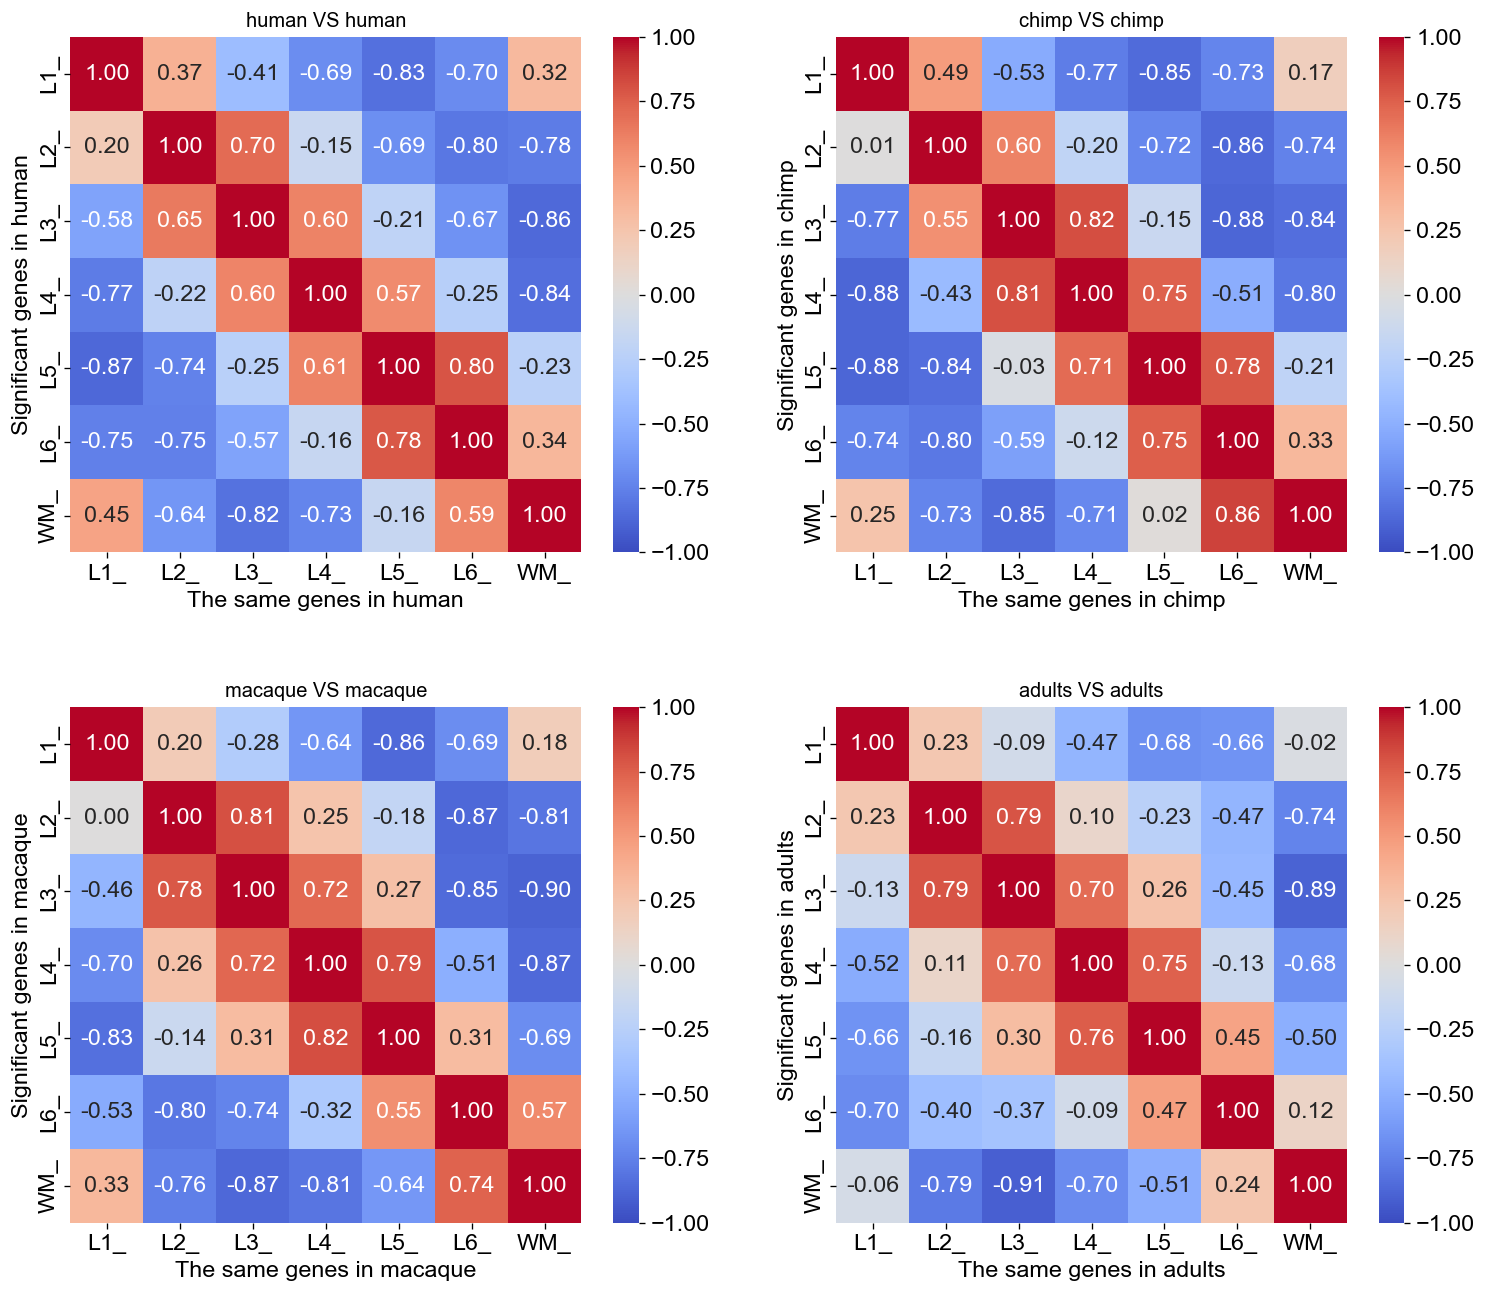

In [25]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2, 'hspace': 0.3}, dpi=60)
de_list = [human_de, chimp_de, macaque_de, adults_de]
species = ['human', 'chimp', 'macaque', 'adults']
de_genes = [human_markers, chimp_markers, macaque_markers, adults_markers]


for de_dict, genes, specie, ax in zip(de_list, de_genes, species, axes.flatten()):
    df = corr_df(de_dict, de_dict, genes, ref_ind='', tar_ind='')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS {specie}', fontsize=12)
    ax.set_ylabel(f'Significant genes in {specie}')
    ax.set_xlabel(f'The same genes in {specie}')
    ax.grid(False)

In [26]:
human_markers_only = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in human_de.items()}
chimp_markers_only = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in chimp_de.items()}
macaque_markers_only = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in macaque_de.items()}
adults_markers_only = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in adults_de.items()}

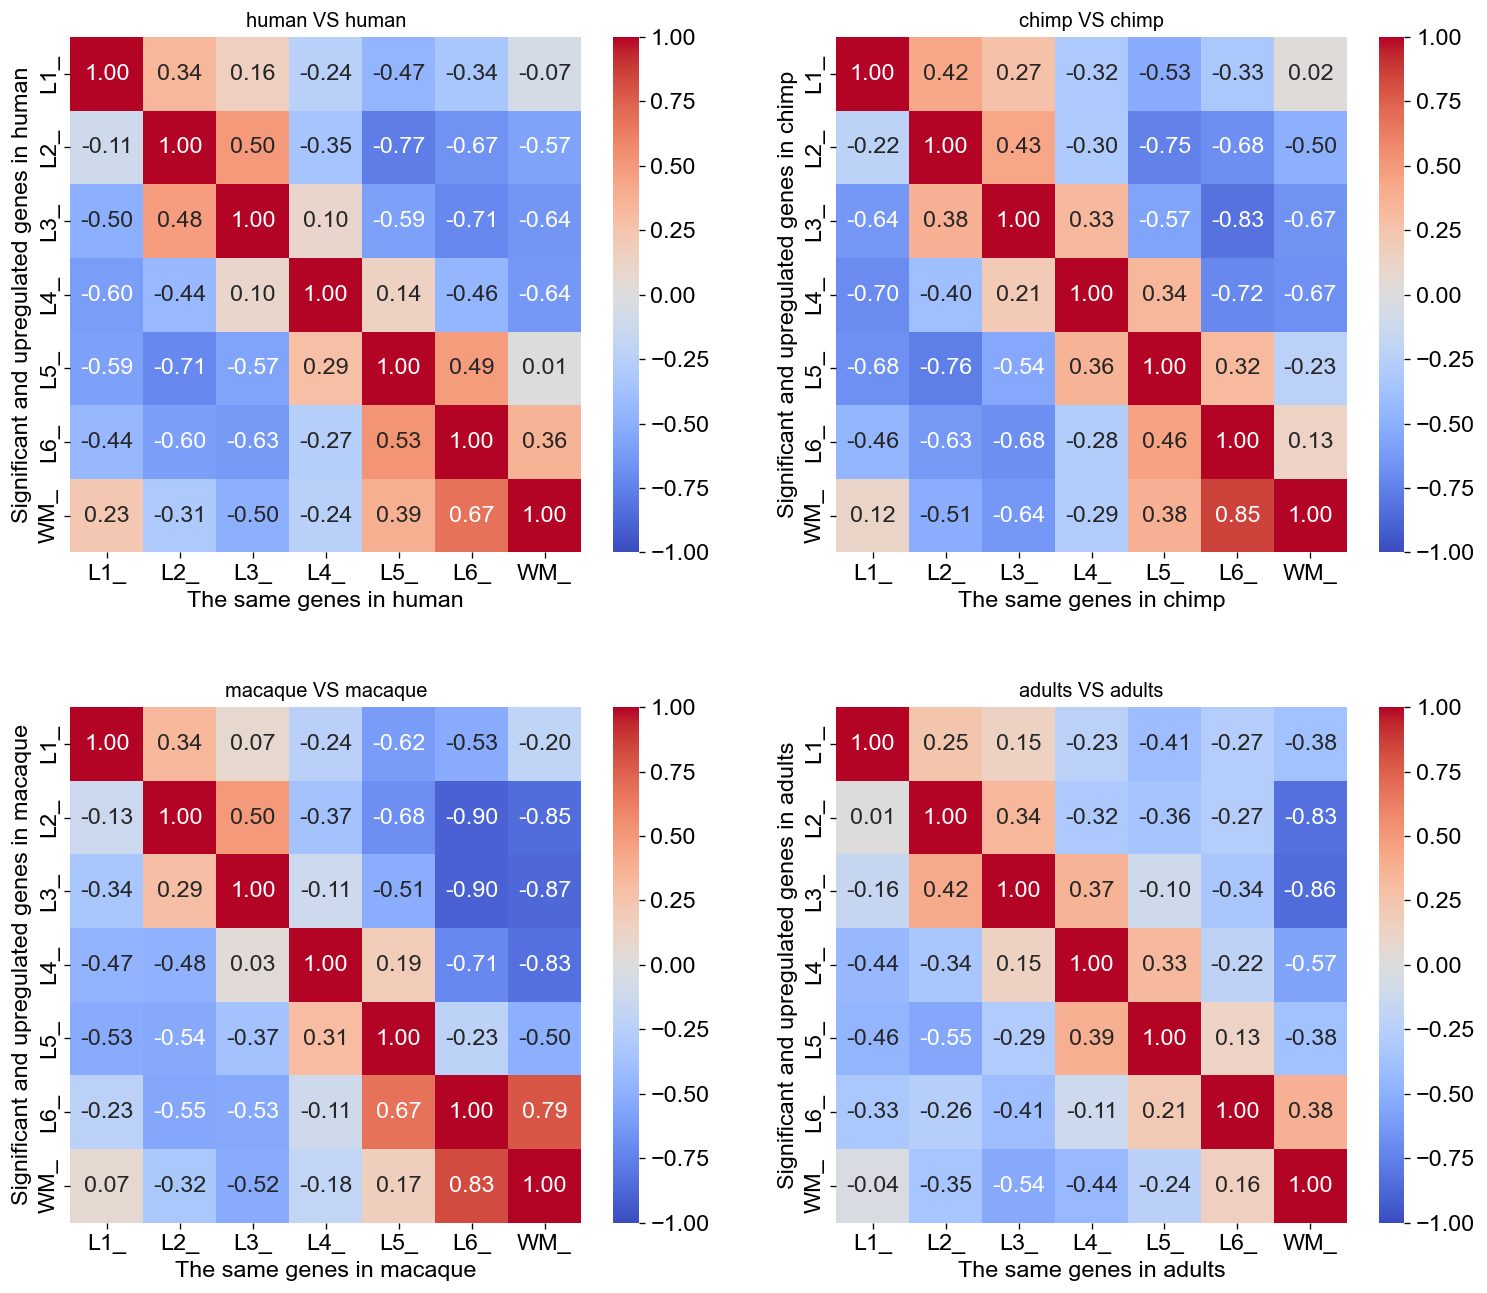

In [27]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2, 'hspace': 0.3}, dpi=60)
de_list = [human_de, chimp_de, macaque_de, adults_de]
species = ['human', 'chimp', 'macaque', 'adults']
marker_genes_only = [human_markers_only, chimp_markers_only, macaque_markers_only, adults_markers_only]


for de_dict, genes, specie, ax in zip(de_list, marker_genes_only, species, axes.flatten()):
    df = corr_df(de_dict, de_dict, genes, ref_ind='', tar_ind='')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS {specie}', fontsize=12)
    ax.set_ylabel(f'Significant and upregulated genes in {specie}')
    ax.set_xlabel(f'The same genes in {specie}')
    ax.grid(False)

### Compare marker genes in adult humans for newborn samples 

In [28]:
import scipy
def corrplots(target_de, ref_de, markers):
    fig, axes = plt.subplots(2, 4,  figsize=(15, 8), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=60)
    for ax, layer in zip(axes.flatten(), layers):
        same_genes = ref_de['L1'].index.intersection(target_de['L1'].index)
        mark = markers[layer].intersection(same_genes)
        ref_genes = ref_de[layer].loc[mark]
        target_genes = target_de[layer].loc[mark]

        corr = scipy.stats.pearsonr(x=ref_genes.logFC, y=target_genes.logFC)
        sns.regplot(x=ref_genes.logFC, y=target_genes.logFC, ax=ax)
        ax.legend([f'r={corr[0]: .2f} pv={corr[1]:.1e}'])
        ax.grid(False)
    fig.delaxes(axes[1, 3])

Let's check all significant genes first

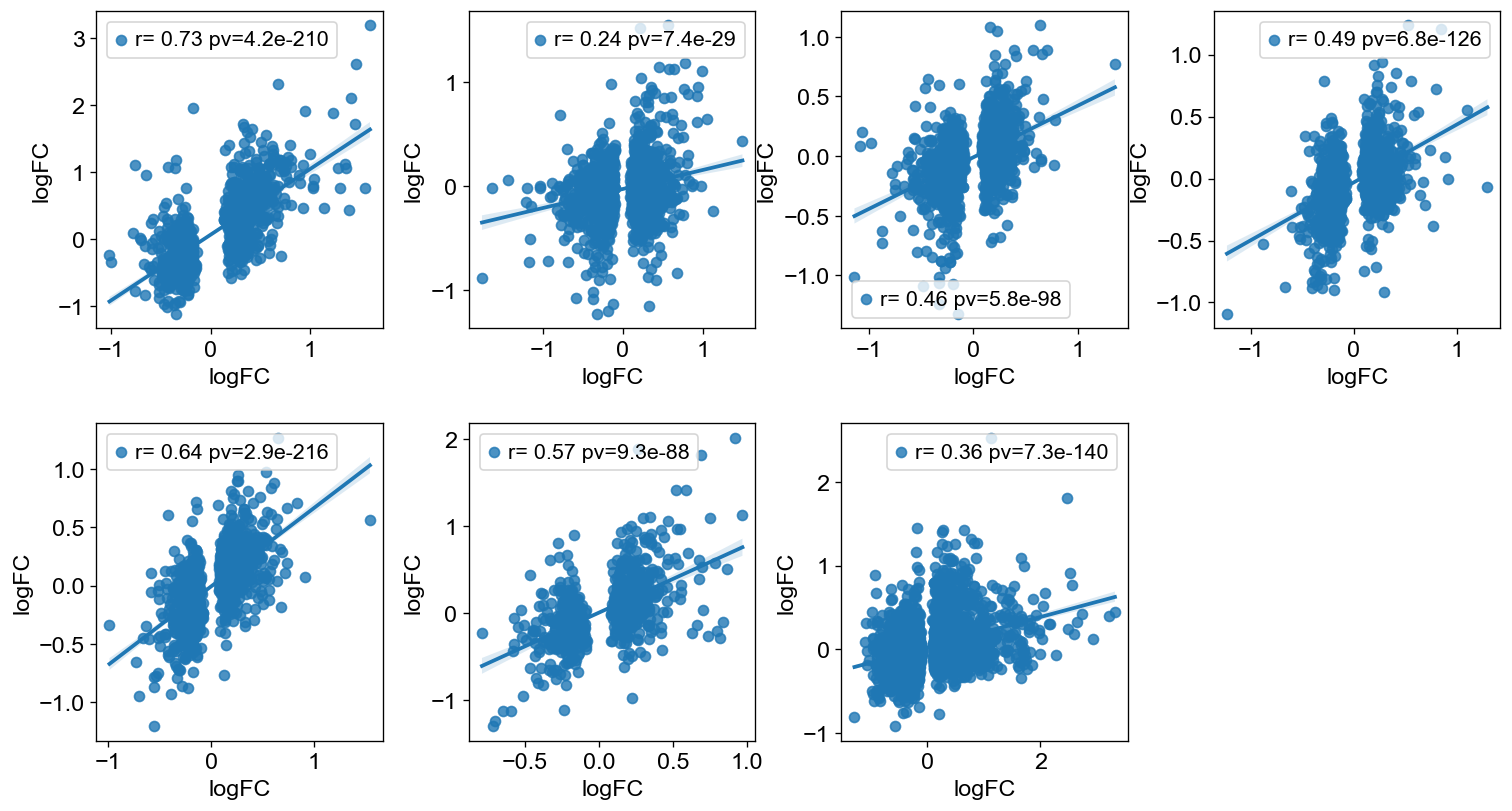

In [29]:
corrplots(human_de, adults_de, adults_markers)

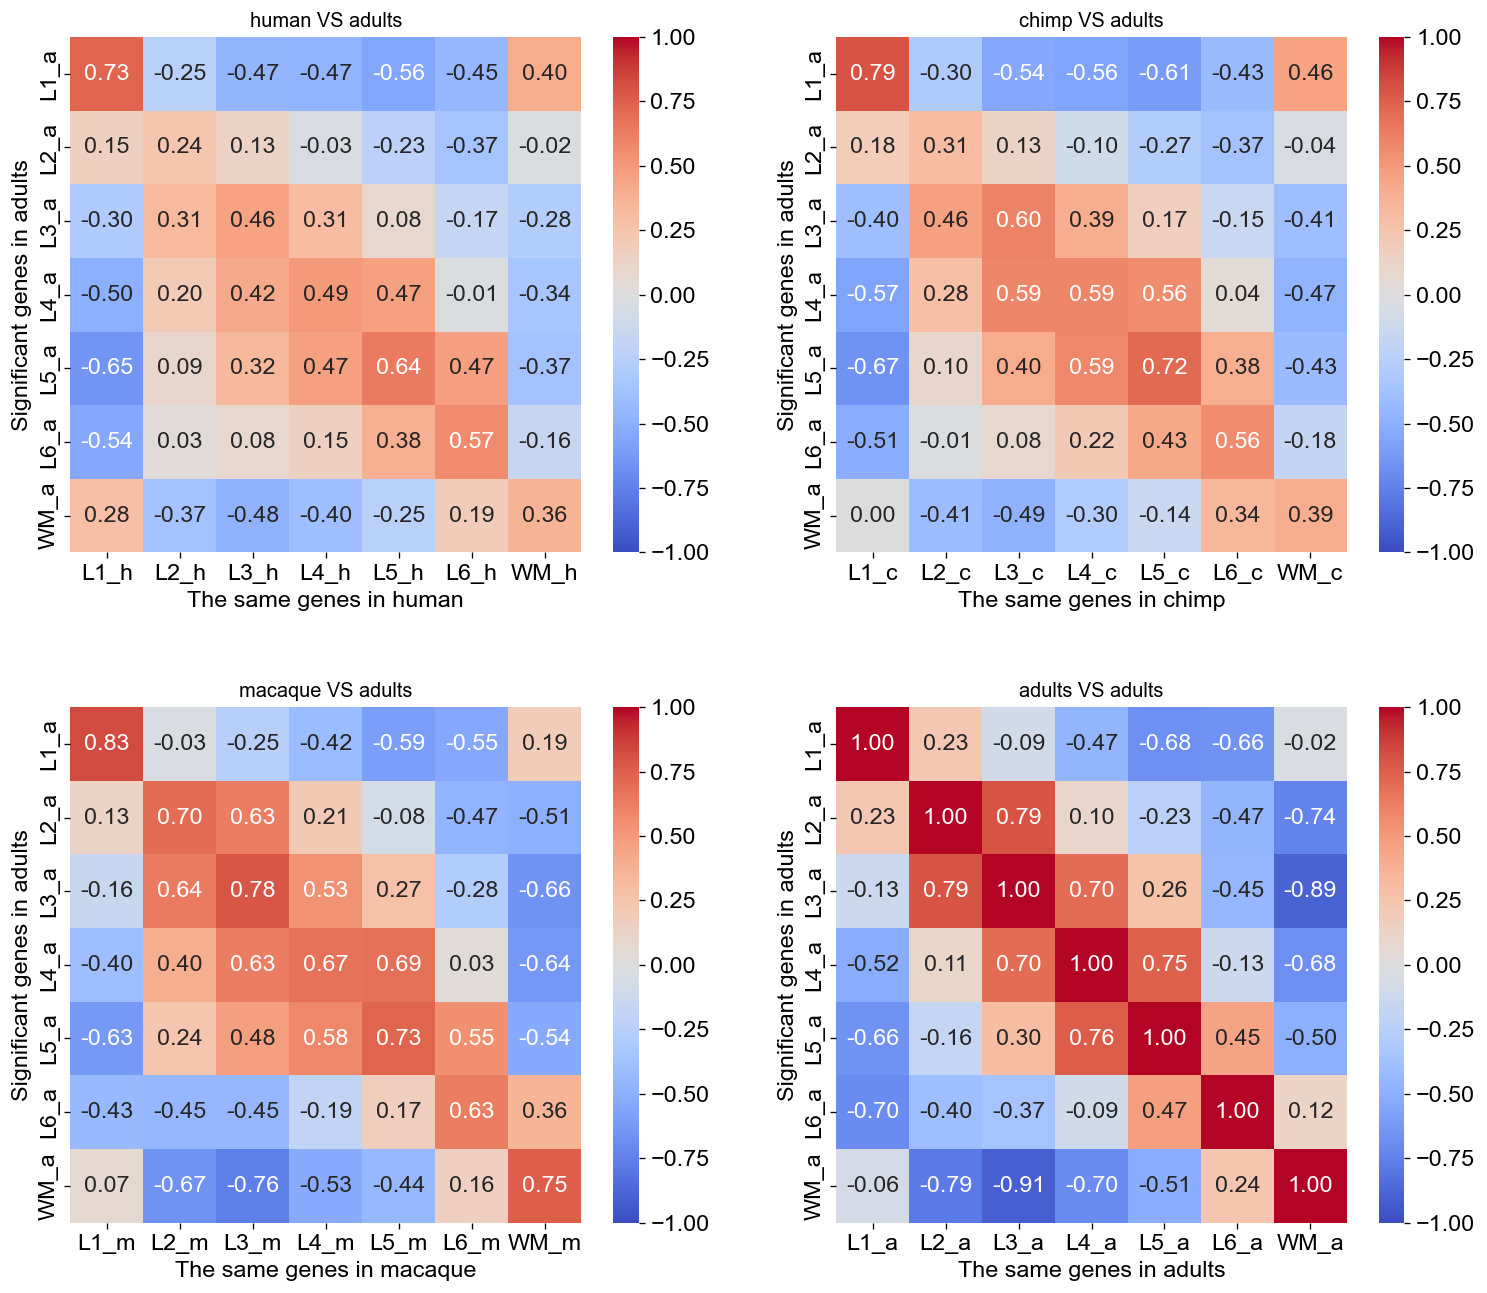

In [30]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2, 'hspace': 0.3}, dpi=60)
for de_dict, specie, ax in zip([human_de, chimp_de, macaque_de, adults_de], ['human', 'chimp', 'macaque', 'adults'], axes.flatten()):
    df = corr_df(de_dict, adults_de, adults_markers, ref_ind=specie[0], tar_ind='a')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS adults', fontsize=12)
    ax.set_ylabel(f'Significant genes in adults')
    ax.set_xlabel(f'The same genes in {specie}')
    ax.grid(False)

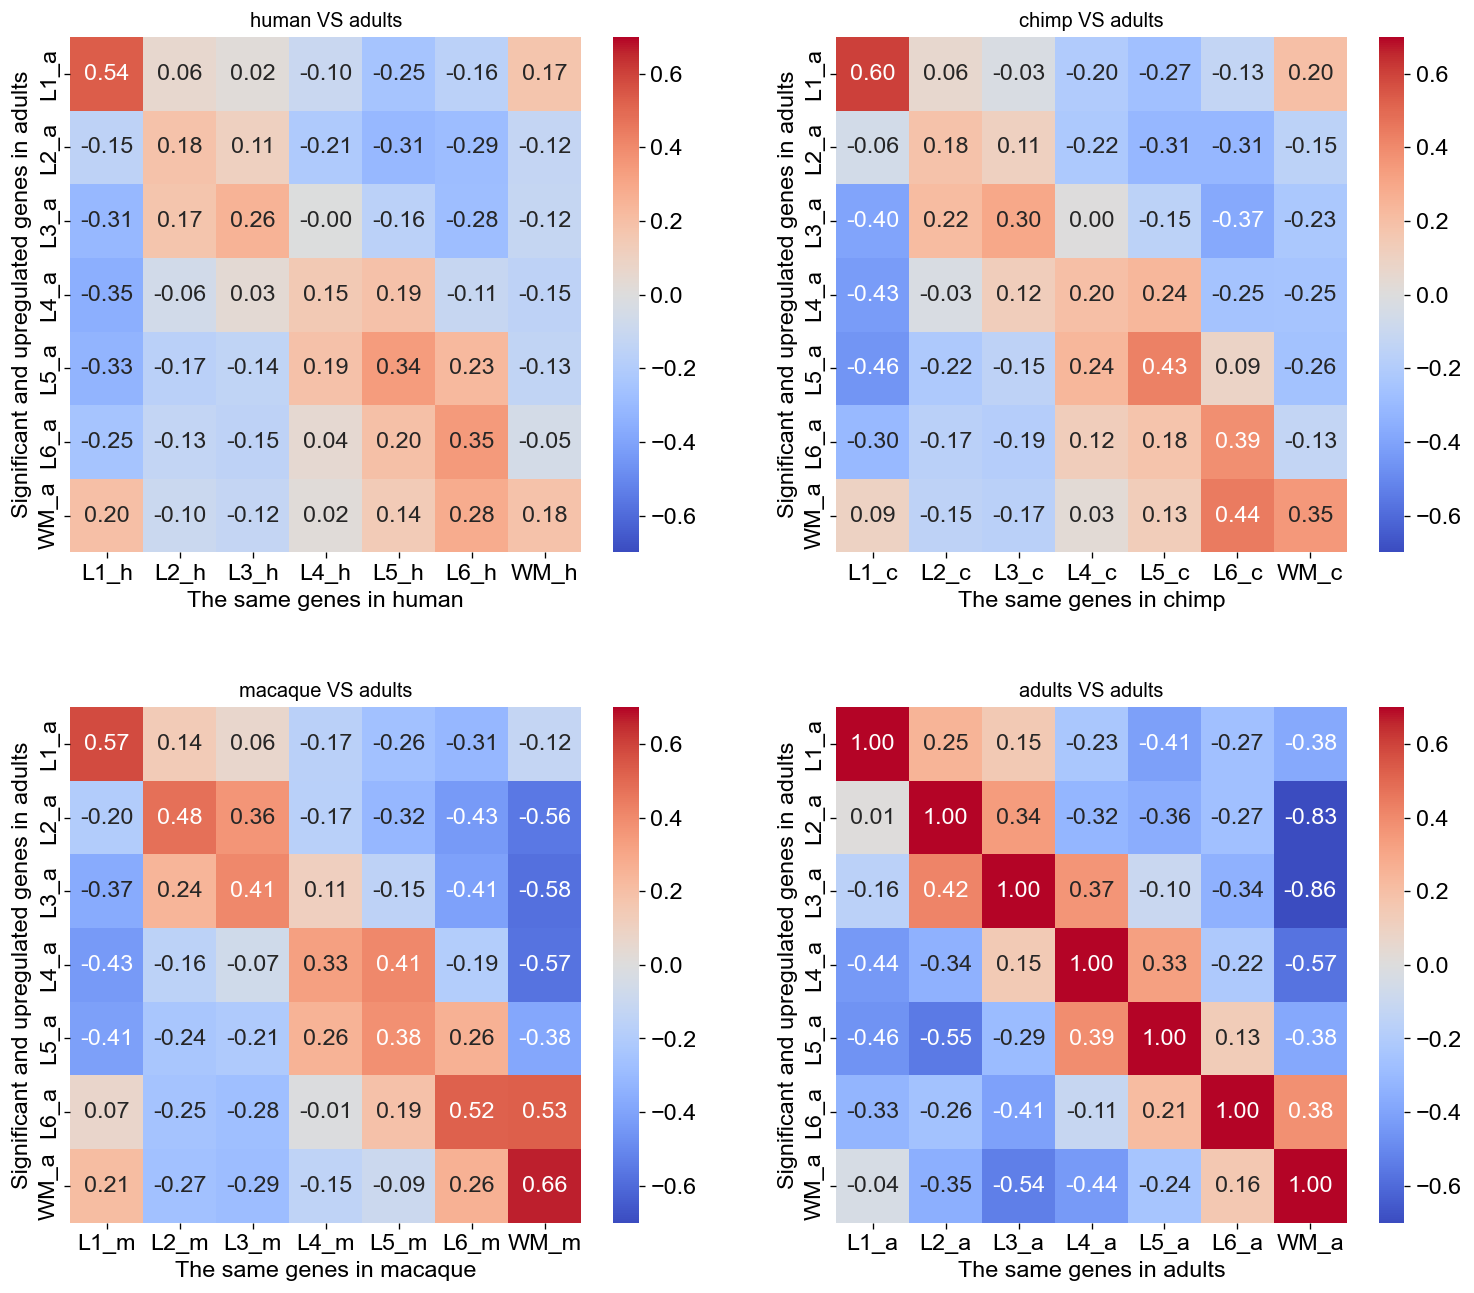

In [31]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2, 'hspace': 0.3}, dpi=60)
for de_dict, specie, ax in zip([human_de, chimp_de, macaque_de, adults_de], ['human', 'chimp', 'macaque', 'adults'], axes.flatten()):
    df = corr_df(de_dict, adults_de, adults_markers_only, ref_ind=specie[0], tar_ind='a')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-0.7, vmax=0.7, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS adults', fontsize=12)
    ax.set_ylabel(f'Significant and upregulated genes in adults')
    ax.set_xlabel(f'The same genes in {specie}')
    ax.grid(False)

### Compare newborn human marker genes

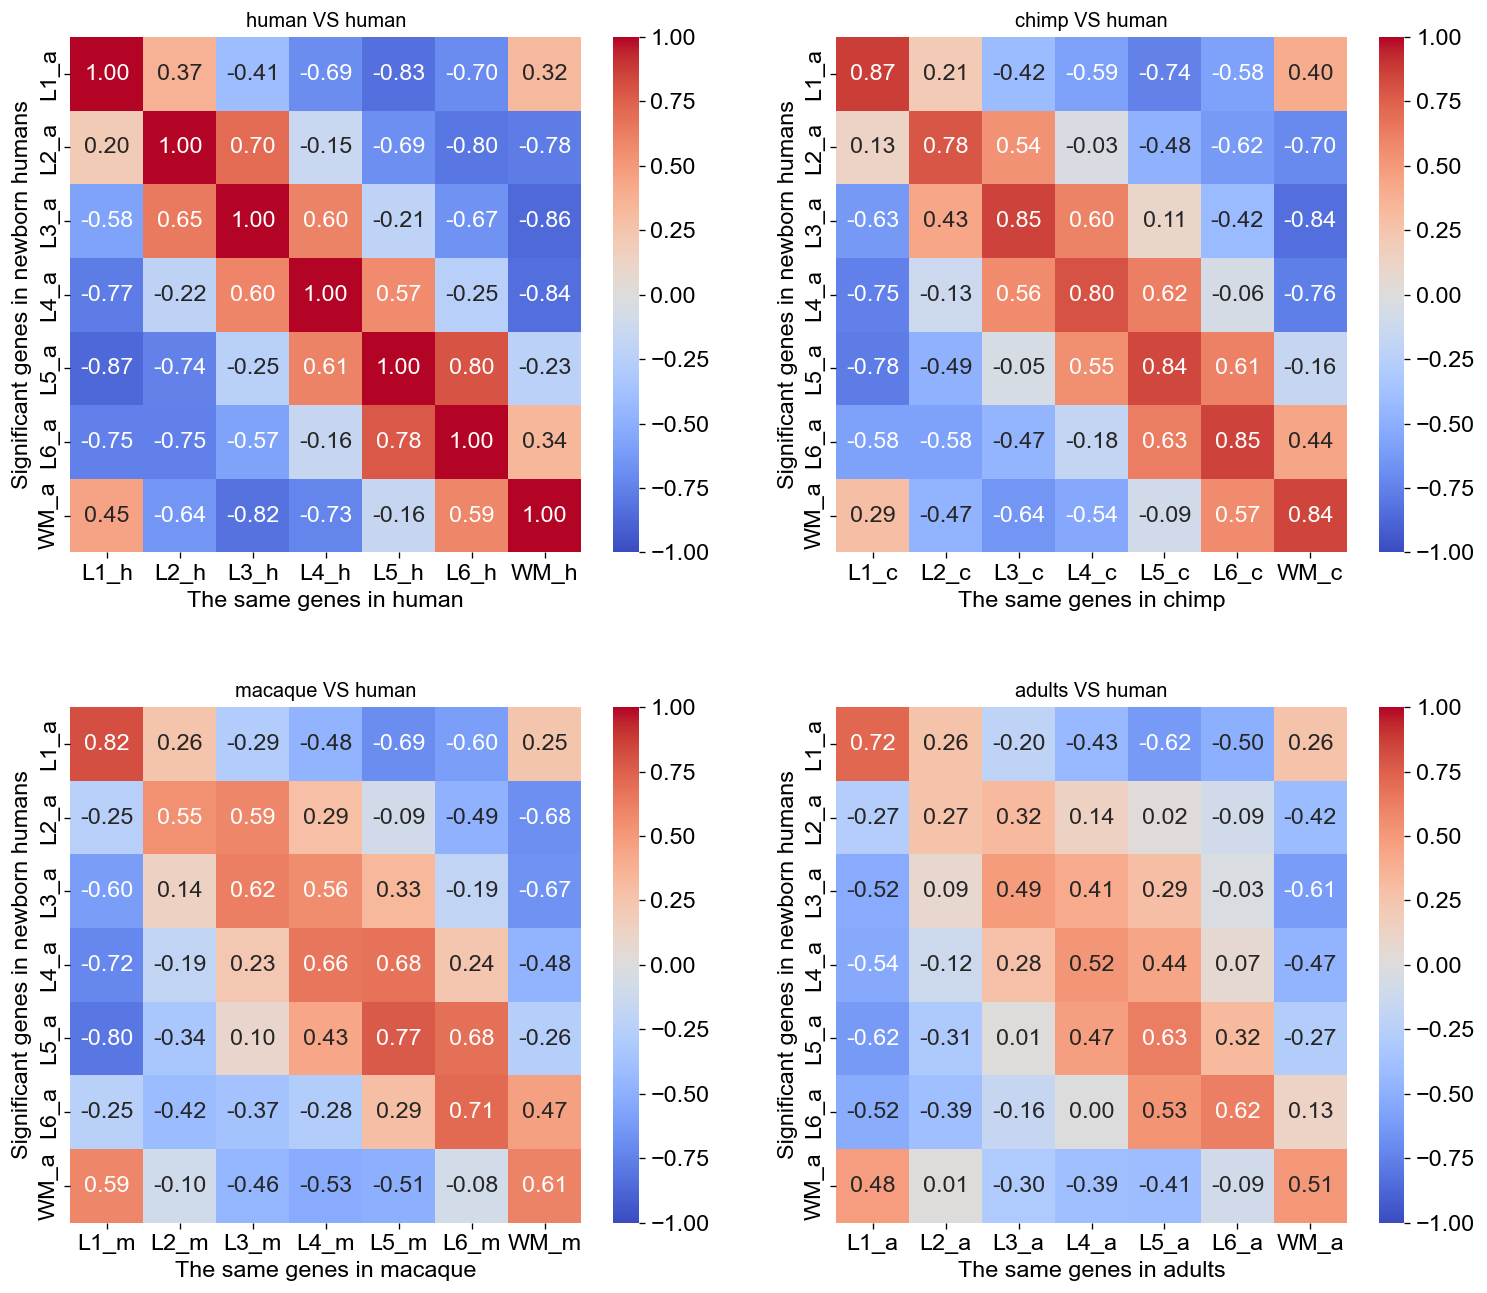

In [32]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2, 'hspace': 0.3}, dpi=60)
for de_dict, specie, ax in zip([human_de, chimp_de, macaque_de, adults_de], ['human', 'chimp', 'macaque', 'adults'], axes.flatten()):
    df = corr_df(de_dict, human_de, human_markers, ref_ind=specie[0], tar_ind='a')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS human', fontsize=12)
    ax.set_ylabel(f'Significant genes in newborn humans')
    ax.set_xlabel(f'The same genes in {specie}')
    ax.grid(False)

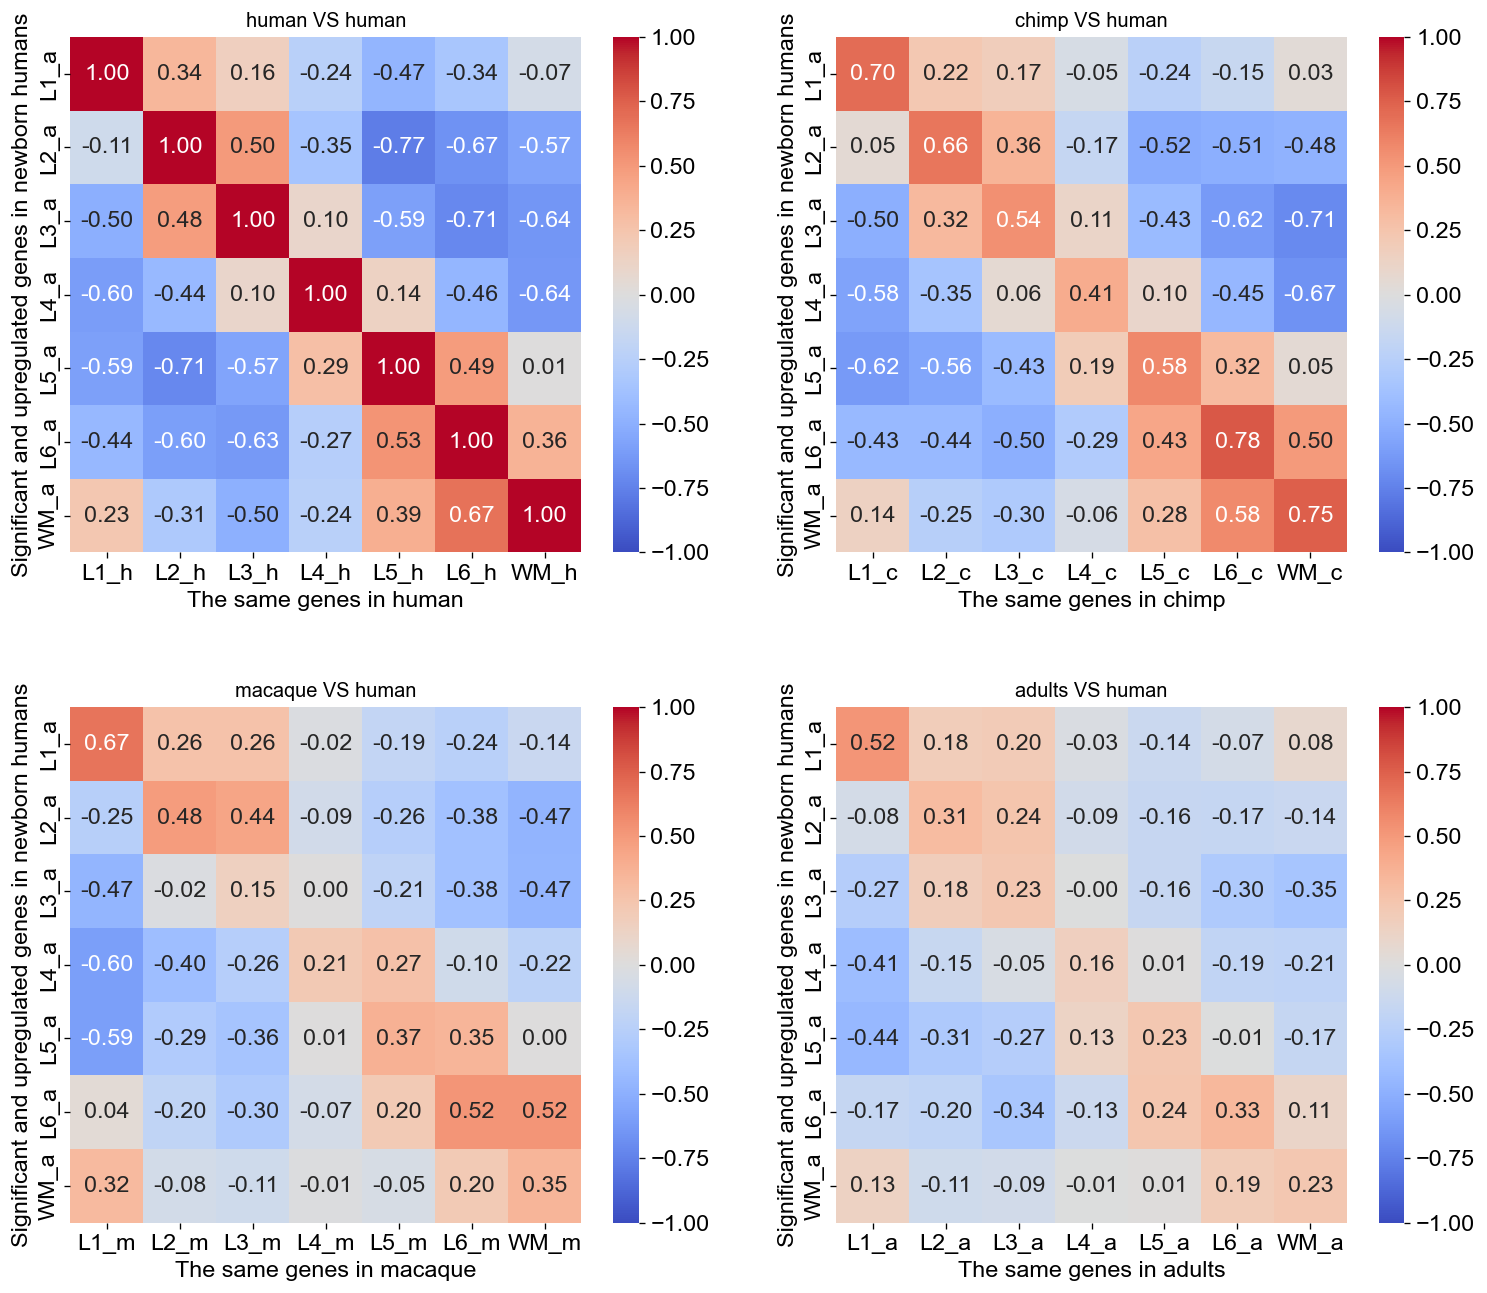

In [33]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2, 'hspace': 0.3}, dpi=60)
for de_dict, specie, ax in zip([human_de, chimp_de, macaque_de, adults_de], ['human', 'chimp', 'macaque', 'adults'], axes.flatten()):
    df = corr_df(de_dict, human_de, human_markers_only, ref_ind=specie[0], tar_ind='a')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS human', fontsize=12)
    ax.set_ylabel(f'Significant and upregulated genes in newborn humans')
    ax.set_xlabel(f'The same genes in {specie}')
    ax.grid(False)

### Unique marker genes

In [1]:
import itertools

def count_unique(marker_dict):
    countgene_list = []
    unique_genes = dict()
    for layer in layers:
        layer_list = []
        for oth_lay in layers:
            if layer == oth_lay:
                marker_genes_other = list(itertools.chain(*[marker_dict[oth_lay] for oth_lay in layers if oth_lay != layer]))
                unique_genes[layer] = set(marker_dict[layer]).difference(marker_genes_other)
                layer_list.append(len(unique_genes[layer]))
            else:
                layer_list.append(len(set(marker_dict[layer]).intersection(marker_dict[oth_lay])))
        countgene_list.append(layer_list)

    countgene_df = pd.DataFrame(countgene_list, index=layers, columns=layers)
    return countgene_df, unique_genes

In [36]:
countgene_adult_df, unique_adult_genes = count_unique(adults_markers)

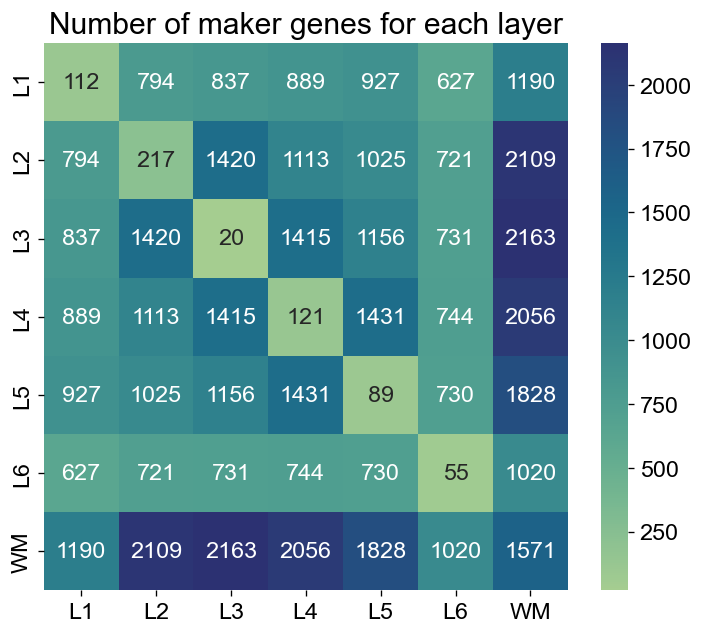

In [37]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_adult_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of maker genes for each layer', fontsize=18)
plt.grid(False)

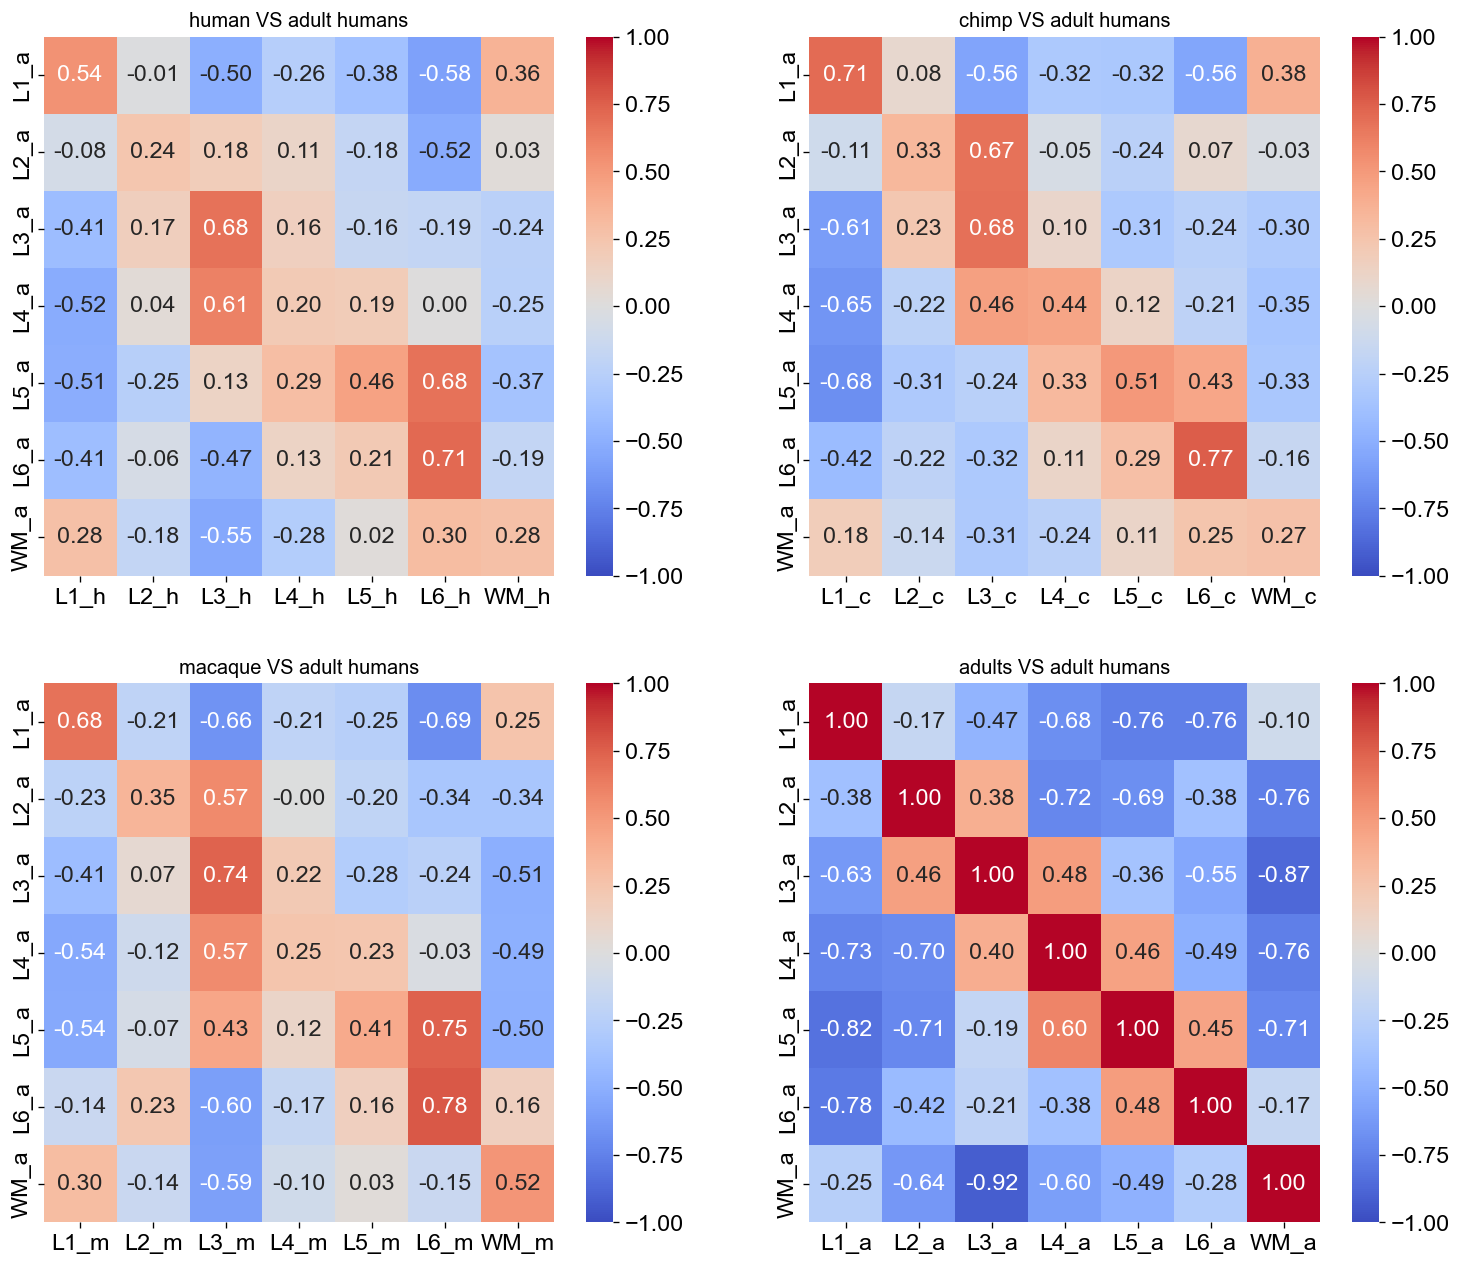

In [38]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2}, dpi=60)
for de_dict, specie, ax in zip([human_de, chimp_de, macaque_de, adults_de], ['human', 'chimp', 'macaque', 'adults'], axes.flatten()):
    df = corr_df(de_dict, adults_de, unique_adult_genes, ref_ind=specie[0], tar_ind='a')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS adult humans', fontsize=12)
    ax.grid(False)

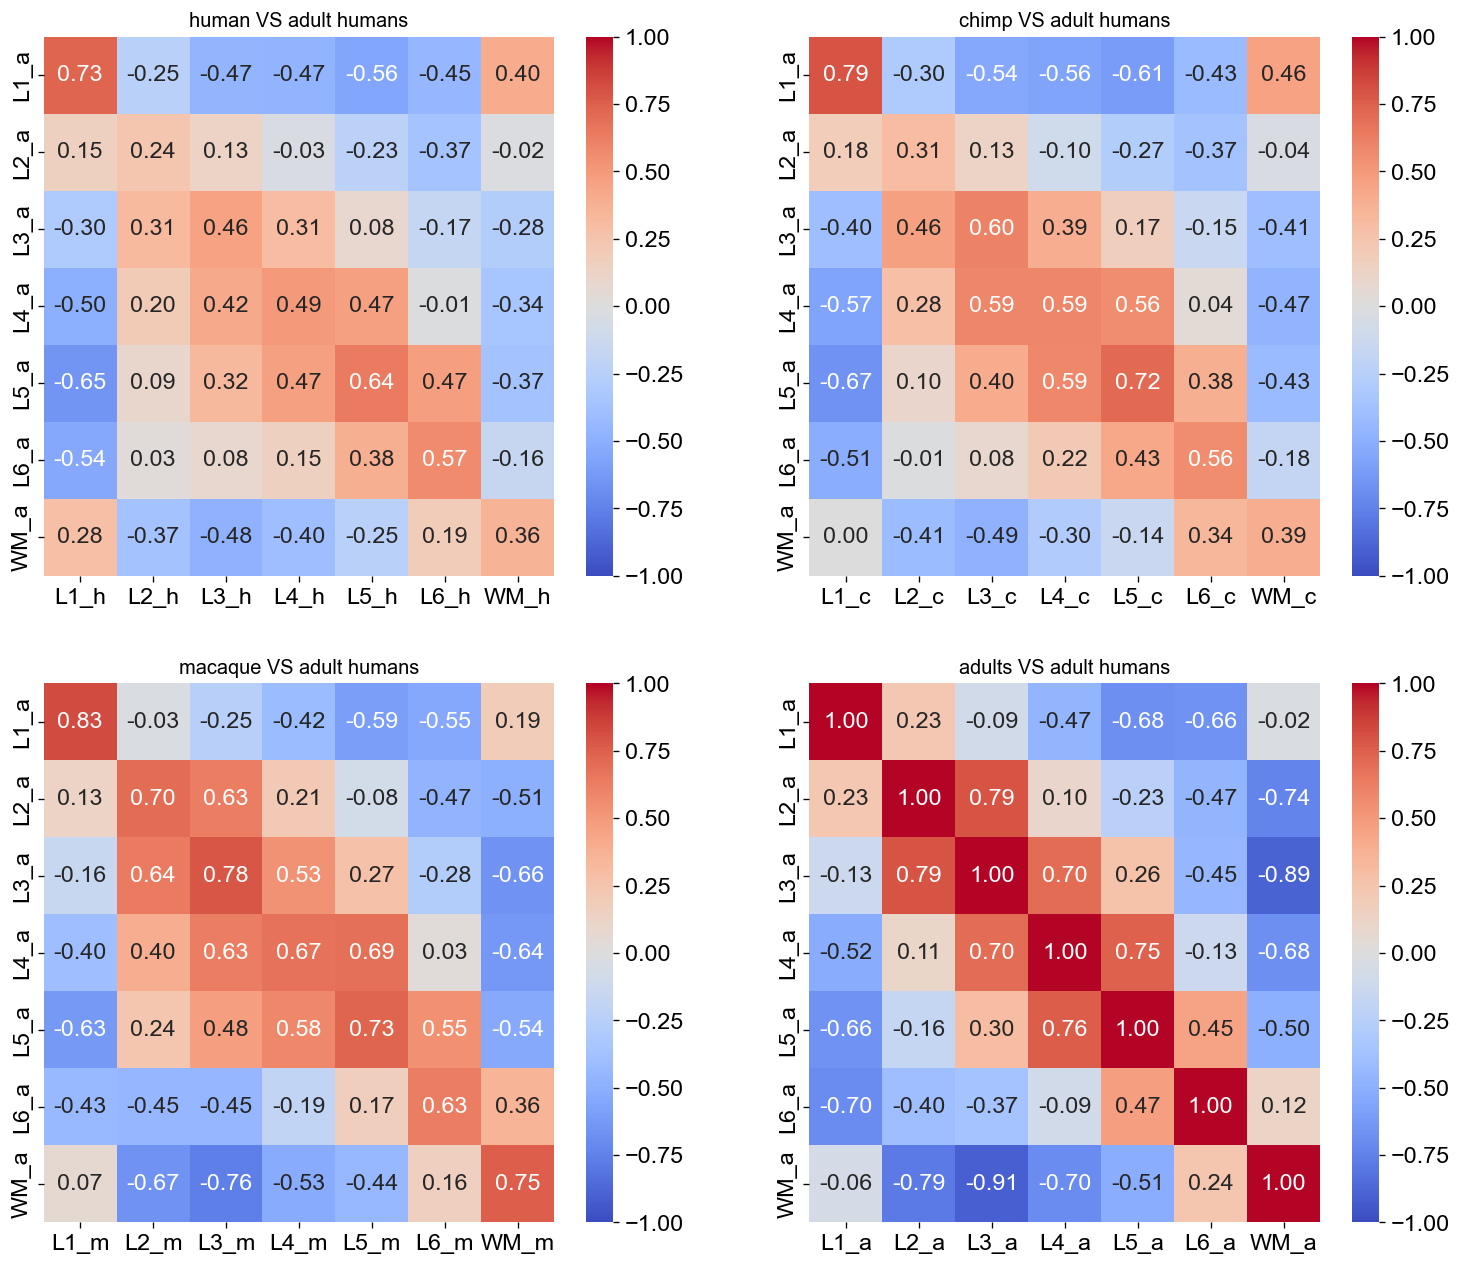

In [39]:
fig, axes = plt.subplots(2, 2,  figsize=(15, 13), gridspec_kw={'wspace': 0.2}, dpi=60)
for de_dict, specie, ax in zip([human_de, chimp_de, macaque_de, adults_de], ['human', 'chimp', 'macaque', 'adults'], axes.flatten()):
    df = corr_df(de_dict, adults_de, adults_markers, ref_ind=specie[0], tar_ind='a')
    sns.heatmap(df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(f'{specie} VS adult humans', fontsize=12)
    ax.grid(False)